<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/3Plane_DTFBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [ ]:
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install opencv-python
!pip install matplotlib
!pip install numpy

## Data import

**import data and get labels**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


## **data generation for meniscus**

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''

    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transformf' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transformf' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'

    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


In [ ]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

num_classes =2

sagittal_mensicus_label = to_categorical(sagittal_mensicus_label, num_classes)
sagittal_mensicus_label_val = to_categorical(sagittal_mensicus_label_val, num_classes)

coronal_mensicus_label = to_categorical(coronal_mensicus_label, num_classes)
coronal_mensicus_label_val = to_categorical(coronal_mensicus_label_val, num_classes)

axial_mensicus_label = to_categorical(axial_mensicus_label, num_classes)
axial_mensicus_label_val = to_categorical(axial_mensicus_label_val, num_classes)


In [ ]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

##  Hyperparameters

In [ ]:
    # Define your parameters
    IMAGE_SIZE = 256  # Adjust based on your actual image dimensions
    CHANNEL = 3
    num_classes = 2  # Binary classification
    batch_size = 32
    nb_epoch =100
    dropout = 0.4
    lr = 5e-5 # Learning rate

## Model Creation and training

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model(input_shape, num_classes, dropout):
    # Base DenseNet model for each plane (axial, coronal, sagittal)
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

    # Define input for each plane
    input_axial = Input(shape=input_shape, name='input_axial')
    input_coronal = Input(shape=input_shape, name='input_coronal')
    input_sagittal = Input(shape=input_shape, name='input_sagittal')

    # Process each plane using the same base DenseNet model
    axial_output = base_model(input_axial)
    coronal_output = base_model(input_coronal)
    sagittal_output = base_model(input_sagittal)

    # Global Average Pooling for each plane
    axial_output = GlobalAveragePooling2D()(axial_output)
    coronal_output = GlobalAveragePooling2D()(coronal_output)
    sagittal_output = GlobalAveragePooling2D()(sagittal_output)

    # Concatenate the outputs from all planes
    concatenated = Concatenate()([ axial_output, coronal_output, sagittal_output])

    # Dense and Dropout layers after concatenation
    x = BatchNormalization()(concatenated)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=[input_axial, input_coronal, input_sagittal], outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
    model = create_model(input_shape, num_classes, dropout)
    #loss='binary_crossentropy'
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Train the model with axial, coronal, and sagittal planes
    history = model.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                        axial_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=([ axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                        callbacks=callbacks_list)

    # Evaluate the model
    predictions_valid = model.predict([ axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score = log_loss(axial_mensicus_label_val, predictions_valid)

    print(f"Log Loss: {score}")
    model.summary()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.5167 - loss: 0.7624
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5172 - loss: 0.7622 - val_accuracy: 0.5500 - val_loss: 0.7283
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5713 - loss: 0.7369
Epoch 2: val_accuracy did not improve from 0.55000
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.5721 - loss: 0.7365 - val_accuracy: 0.5417 - val_loss: 0.7069
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5908 - loss: 0.7245
Epoch 3: val_accuracy improved from 0.55000 to 0.56667, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.5912 - loss: 0.7241 - val_accuracy: 0.5667 - val_loss: 0.7021
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6042 - loss: 0.7162
Epoch 4: val_accuracy improved from 0.56667 to 0.59167, saving model to bestm

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_axial (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_coronal             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sagittal            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 8, 8, 1024)     │      7,037,504 │ input_axial[0][0],     │
│                           │                        │                │ input_coronal[0][0],   │
│                           │                        │                │ input_sagittal[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[2][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3072)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 3072)           │         12,288 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 3072)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      3,146,752 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │          2,050 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,452,742 (58.95 MB)

 Trainable params: 4,204,546 (16.04 MB)

 Non-trainable params: 7,043,648 (26.87 MB)

 Optimizer params: 4,204,548 (16.04 MB)

## Model evaluation

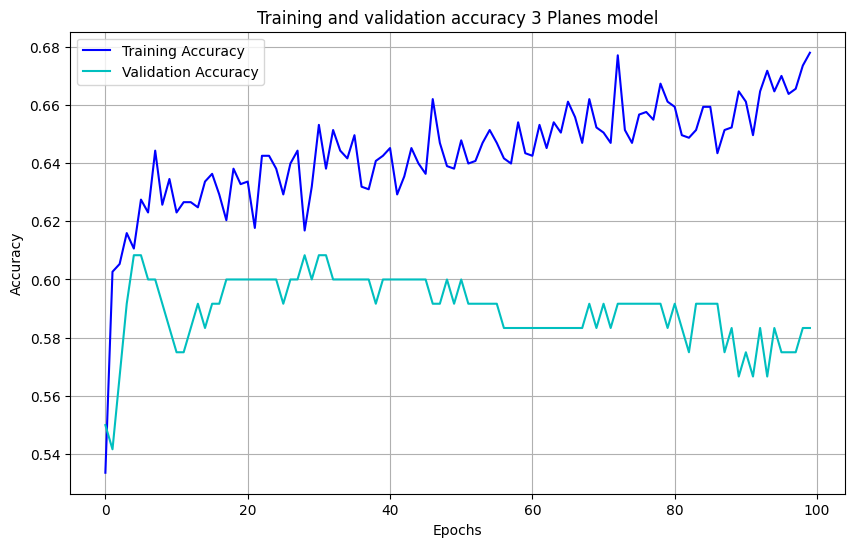

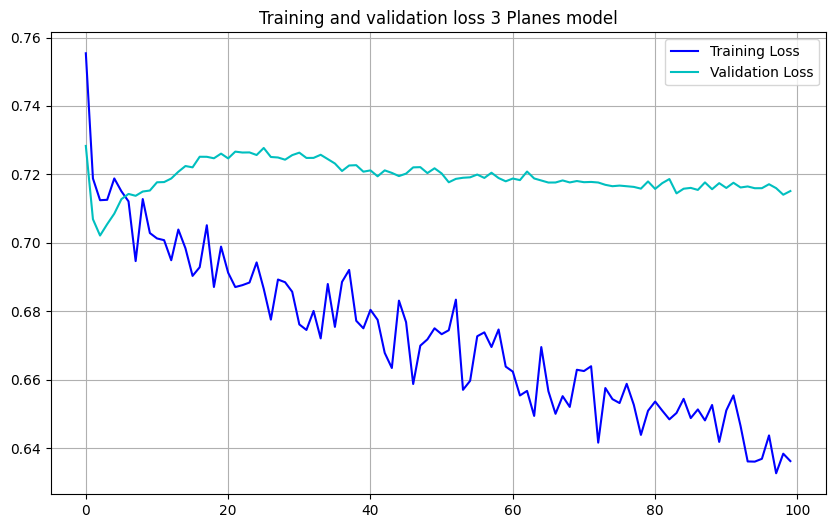

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'c',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title(f'Training and validation accuracy 3 Planes model')
plt.grid(True)
plt.legend()
plt.savefig(f'Training and validation accuracy 3 Planes model.png')




#Plot training and validation loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'c',label='Validation Loss')


plt.title(f'Training and validation loss 3 Planes model')
plt.savefig(f'Training and validation loss 3 Planes model.png')
plt.grid(True)
plt.legend()

plt.show()


In [ ]:
# Function to calculate accuracy and misclassification
def calculate_accuracy(ypred, ytest):
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [ ]:

# Axial plane accuracy
total, accurate, wrong, accuracy, accurateindex, wrongindex = calculate_accuracy(predictions_valid, axial_mensicus_label_val)
print(' - Total test data:', total, '\tAccurately predicted data:', accurate, '\tWrongly predicted data:', wrong)
print(' Accuracy:', accuracy, '%')

 - Total test data: 120 	Accurately predicted data: 70 	Wrongly predicted data: 50
 Accuracy: 58.333 %


In [ ]:
model.save("3Plane_DTFBN.keras")
from google.colab import files
files.download('3Plane_DTFBN.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("Training and validation accuracy 3Plane_DTFBN.png")
files.download("Training and validation loss 3Plane_DTFBN.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>